## Test Adult dataset
- Document of dataset: 
    + https://fairlearn.org/main/user_guide/datasets/acs_income.html#dataset-description
    + https://fairlearn.org/main/api_reference/generated/fairlearn.datasets.fetch_adult.html
    + https://archive.ics.uci.edu/dataset/2/adult


In [2]:
# Custom imports
# import my_helper # my helper functions
from TabResNet import TabResNet
from MLP import MLP

# General imports
from IPython.display import Markdown, display, clear_output
from functools import partial
import pathlib
import numpy as np
import pandas as pd
import shap

# DL imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

# Choose the fairness metric
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

# Some "difference" metrics (as in Nils' paper)
# All ranges are [0,1] -> no need to scale 
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    true_positive_rate_difference,
    false_positive_rate_difference,
)

torch.manual_seed(27)
clear_output()
np.random.seed(27)

## Data Loading

In [3]:
# ---------------------------
# Data Loading and Preparation
# ---------------------------
# X_display, y_display = shap.datasets.adult(display=True)

# Load the dataset which has been label-encoded
X, y = shap.datasets.adult()

In [4]:
y_df = pd.DataFrame(y)

In [5]:
print(y_df.value_counts(normalize=True))

0    
False    0.75919
True     0.24081
Name: proportion, dtype: float64


## Data Preprocessing

### Label Encoding
Already done by SHAP - only need to drop attributes column "Sex"

In [6]:
X_le = X.drop(columns=["Sex"])

### Data Splitting & Formatting

In [7]:
random_state = 7
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_le, y, X["Sex"], test_size=0.2, random_state=random_state
)

In [8]:
# Combine into DataFrame for easy grouping
df_test = pd.DataFrame({
    'Sex': A_test,
    'Label': y_test
})

# Count distribution of classes per group
distribution = df_test.groupby('Sex')['Label'].value_counts(normalize=True).unstack()
print("Class distribution by sex group (as percentage):")
print((distribution * 100).round(2))


Class distribution by sex group (as percentage):
Label  False  True 
Sex                
0      88.99  11.01
1      69.54  30.46


In [9]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of A_train: ", A_train.shape)
print("Shape of A_test: ", A_test.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (26048, 11)
Shape of y_train:  (26048,)
Shape of A_train:  (26048,)
Shape of A_test:  (6513,)
Shape of X_test:  (6513, 11)
Shape of y_test:  (6513,)


In [10]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

# Convert all data to integers -> avoid errors in training
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

# Convert data to tensors
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)
X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np) #.type(torch.LongTensor) 


## Train

### MLP

In [11]:
INPUT_DIM     = X_test.shape[1]
NUM_CLASSES   = 2
HIDDEN_DIM    = 50
LEARNING_RATE = 1e-3


mlp_model = MLP(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)

In [12]:
# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    # Forward pass
    logits = mlp_model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/400], Loss: 0.4618
Epoch [200/400], Loss: 0.3935
Epoch [300/400], Loss: 0.3641
Epoch [400/400], Loss: 0.3535


In [13]:
# Evaluate on test data
mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(X_test_tensor) 
    probs = torch.softmax(logits, dim=1)
    mlp_preds = torch.argmax(probs, dim=1)
    accuracy = (mlp_preds == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8356


In [25]:
# Save the model
torch.save(mlp_model.state_dict(), "saved_model/mlp_adult.pth")

In [ ]:
# Load the model
mlp_model.load_state_dict(torch.load("saved_model/mlp_adult.pth"))

C:\Users\hungd\AppData\Local\Temp\ipykernel_21172\2015773111.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load("saved_model/mlp_german

<All keys matched successfully>

### TabResNet

In [15]:
# Instantiate model
model = TabResNet(
    d_in=X_test.shape[1], # Match input features
    d_out=2,
    n_blocks=2,
    d_block=32,
    d_hidden=64,
    dropout1=0.2,
    dropout2=0.05
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 400

In [16]:

for epoch in range(num_epochs):
    model.train()
    logits = model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [100/400], Loss: 0.4955
Epoch [200/400], Loss: 0.3927
Epoch [300/400], Loss: 0.3306
Epoch [400/400], Loss: 0.3245


In [17]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor) 
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8485


In [26]:
# Save the model
torch.save(mlp_model.state_dict(), "saved_model/tabresnet_adult.pth")

## Results

### Predicted positive counts by group (Income):

In [18]:
# Combine into DataFrame for easy grouping
df_test = pd.DataFrame({
    'Sex': A_test,
    'Label': y_test
})

# Count distribution of classes per group
distribution = df_test.groupby('Sex')['Label'].value_counts(normalize=True).unstack()
print("Class distribution by Sex group (as percentage) - Income Dataset:")
print((distribution * 100).round(2))

Class distribution by Sex group (as percentage) - Income Dataset:
Label  False  True 
Sex                
0      88.99  11.01
1      69.54  30.46


Imbalance Assessment

ACSIncome:

Sex 0 (likely female): 11.01% positive, Sex 1 (likely male): 30.46% positive.

Huge class imbalance (over 19 percentage points) between groups — clear structural disparity.

Despite this, models like TabResNet managed relatively good fairness (0.9191), suggesting it was better at mitigating inherent bias.

In [19]:
print("Predicted positive counts by group of Model MLP:")
print(pd.Series(mlp_preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model MLP:
Sex
0    176
1    959
dtype: int64


In [20]:
print("Predicted positive counts by group of Model TabResNet:")
print(pd.Series(preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model TabResNet:
Sex
0     180
1    1085
dtype: int64


### MLP

array([[<Axes: title={'center': 'Accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'Precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Count'}, xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

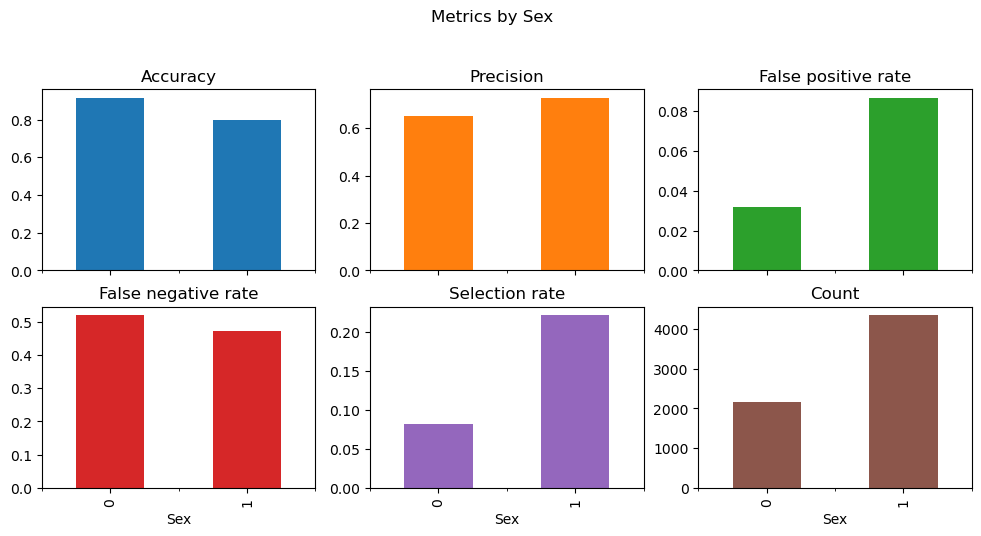

In [21]:
# Plot metrics using MetricFrame
mlp_metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

mlp_metric_frame = MetricFrame(
    metrics=mlp_metrics, y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test
)

# Plotting
mlp_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [22]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
mlp_accuracy_values = mlp_metric_frame.by_group["Accuracy"]
mlp_acc_diff = mlp_accuracy_values.max() - mlp_accuracy_values.min()
print(f"Accuracy difference: {mlp_acc_diff:.4f}")

# Precision difference
mlp_precision_values = mlp_metric_frame.by_group["Precision"]
mlp_prec_diff = mlp_precision_values.max() - mlp_precision_values.min()
print(f"Precision difference: {mlp_prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_tpr_values = 1 - mlp_metric_frame.by_group["False negative rate"]
mlp_tpr_diff = mlp_tpr_values.max() - mlp_tpr_values.min() 
print(f"True positive rate difference: {mlp_tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_fpr_values = mlp_metric_frame.by_group["False positive rate"]
mlp_fpr_diff = mlp_fpr_values.max() - mlp_fpr_values.min()
print(f"False positive rate difference: {mlp_fpr_diff:.4f}")

# Demographic parity (DemP) difference
mlp_dp_diff = demographic_parity_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Demographic parity difference: {mlp_dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
mlp_eo_diff = equalized_odds_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Equalized odds difference: {mlp_eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.1188
Precision difference: 0.0744
True positive rate difference: 0.0464
False positive rate difference: 0.0548
Demographic parity difference: 0.1397
Equalized odds difference: 0.0548


### TabResNet

array([[<Axes: title={'center': 'Accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'Precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'Count'}, xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

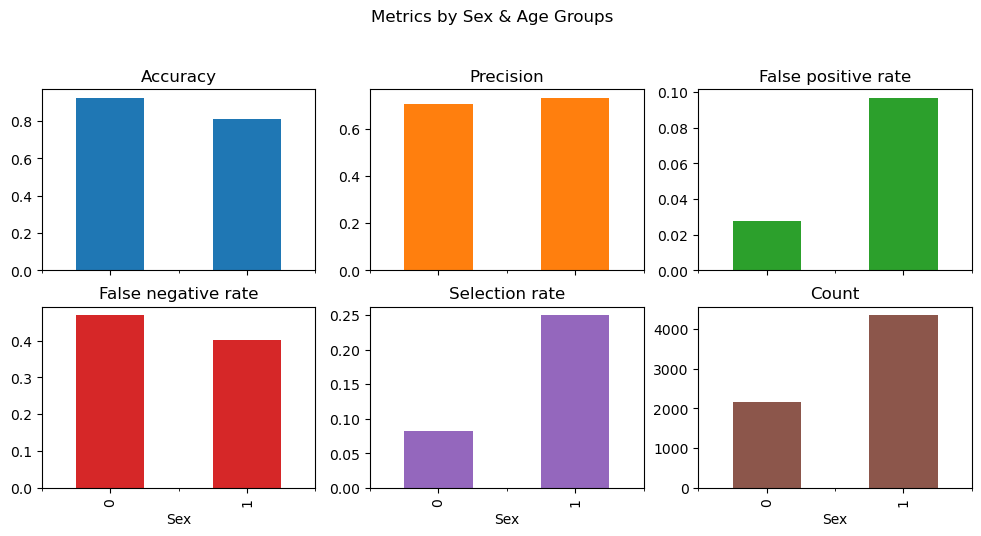

In [23]:
# Plot metrics using MetricFrame
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=preds, sensitive_features=A_test
)

# Plotting
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex & Age Groups",
)

In [24]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
accuracy_values = metric_frame.by_group["Accuracy"]
acc_diff = accuracy_values.max() - accuracy_values.min()
print(f"Accuracy difference: {acc_diff:.4f}")

# Precision difference
precision_values = metric_frame.by_group["Precision"]
prec_diff = precision_values.max() - precision_values.min()
print(f"Precision difference: {prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
tpr_values = 1 - metric_frame.by_group["False negative rate"]
tpr_diff = tpr_values.max() - tpr_values.min() 
print(f"True positive rate difference: {tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
fpr_values = metric_frame.by_group["False positive rate"]
fpr_diff = fpr_values.max() - fpr_values.min()
print(f"False positive rate difference: {fpr_diff:.4f}")

# Demographic parity (DemP) difference
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Demographic parity difference: {dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Equalized odds difference: {eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.1132
Precision difference: 0.0253
True positive rate difference: 0.0680
False positive rate difference: 0.0692
Demographic parity difference: 0.1669
Equalized odds difference: 0.0692
